# Import Data

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss

import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout
from keras.optimizers import SGD, RMSprop, Adam, Nadam
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers

Using TensorFlow backend.


In [2]:
os.getcwd()

'C:\\Users\\irie9\\Python\\Competition\\Competition2'

In [3]:
df = pd.read_csv("default of credit card clients.csv")
df.columns = df.iloc[0, :]
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object', name=0)

In [4]:
df = df.drop(0, axis=0)
df.columns = ["ID", "LIMIT_BAL", "SEX", "EDUCATION", "MARRIAGE", "AGE", "PAYSTATE_9",
             "PAYSTATE_8", "PAYSTATE_7", "PAYSTATE_6", "PAYSTATE_5", "PAYSTATE_4", "BILL_AMT9", "BILL_AMT8",
             "BILL_AMT7", "BILL_AMT6", "BILL_AMT5", "BILL_AMT4", "PAY_AMT9", "PAY_AMT8", "PAY_AMT7", "PAY_AMT6",
             "PAY_AMT5", "PAY_AMT4", "DEFAULT"]
df = df.astype(float)
df = df.reset_index().drop("index", axis=1)

# Feature Engineering

In [5]:
df["DEFAULT"].value_counts()
6636/30000

0.2212

In [6]:
# Average Bill Statement & Payment
df["BILL_AVG"] = df[["BILL_AMT9", "BILL_AMT8", "BILL_AMT7", "BILL_AMT6", "BILL_AMT5", "BILL_AMT4"]].mean(axis=1)
df["PAY_AVG"] = df[["PAY_AMT9", "PAY_AMT8", "PAY_AMT7", "PAY_AMT6", "PAY_AMT5", "PAY_AMT4"]].mean(axis=1)

In [7]:
# Binning Age
df["AGE"].max(), df["AGE"].min()

(79.0, 21.0)

In [9]:
def f(df) :
    if (df["AGE"] >= 20) & (df["AGE"] < 30) :
        return "20s"
    elif (df["AGE"] >= 30) & (df["AGE"] < 40) :
        return "30s"
    elif (df["AGE"] >= 40) & (df["AGE"] < 50) :
        return "40s"
    elif (df["AGE"] >= 50) & (df["AGE"] < 60) :
        return "50s"
    elif (df["AGE"] >= 60) & (df["AGE"] < 70) :
        return "60s"
    else :
        return "70s"

df["AGE_GROUP"] = df.apply(lambda df: f(df), axis=1)

In [10]:
print(df.AGE_GROUP.value_counts())
df.groupby("AGE_GROUP")["DEFAULT"].value_counts()

30s    11238
20s     9618
40s     6464
50s     2341
60s      314
70s       25
Name: AGE_GROUP, dtype: int64


AGE_GROUP  DEFAULT
20s        0.0        7421
           1.0        2197
30s        0.0        8962
           1.0        2276
40s        0.0        4979
           1.0        1485
50s        0.0        1759
           1.0         582
60s        0.0         225
           1.0          89
70s        0.0          18
           1.0           7
Name: DEFAULT, dtype: int64

In [11]:
## older age group tends to delay their payments
rate_20s = 2197/11238 ## 0
rate_30s = 2276/9618 ## 1
rate_40s = 1485/6464 ## 2
rate_50s = 582/2341 ## 3
rate_60s = 89/314 ## 4
rate_70s = 7/25 ## 5
print(rate_20s, rate_30s, rate_40s, rate_50s, rate_60s, rate_70s)

0.1954974194696565 0.23663963401954669 0.2297339108910891 0.24861170439982913 0.28343949044585987 0.28


In [13]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAYSTATE_9,PAYSTATE_8,PAYSTATE_7,PAYSTATE_6,...,PAY_AMT9,PAY_AMT8,PAY_AMT7,PAY_AMT6,PAY_AMT5,PAY_AMT4,DEFAULT,BILL_AVG,PAY_AVG,AGE_GROUP
0,1.0,20000.0,2.0,2.0,1.0,24.0,2.0,2.0,-1.0,-1.0,...,0.0,689.0,0.0,0.0,0.0,0.0,1.0,1284.000000,114.833333,20s
1,2.0,120000.0,2.0,2.0,2.0,26.0,-1.0,2.0,0.0,0.0,...,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1.0,2846.166667,833.333333,20s
2,3.0,90000.0,2.0,2.0,2.0,34.0,0.0,0.0,0.0,0.0,...,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0.0,16942.166667,1836.333333,30s
3,4.0,50000.0,2.0,2.0,1.0,37.0,0.0,0.0,0.0,0.0,...,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0.0,38555.666667,1398.000000,30s
4,5.0,50000.0,1.0,2.0,1.0,57.0,-1.0,0.0,-1.0,0.0,...,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0.0,18223.166667,9841.500000,50s


In [14]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["AGE_GROUP"] = le.fit_transform(df["AGE_GROUP"])

In [15]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAYSTATE_9,PAYSTATE_8,PAYSTATE_7,PAYSTATE_6,...,PAY_AMT9,PAY_AMT8,PAY_AMT7,PAY_AMT6,PAY_AMT5,PAY_AMT4,DEFAULT,BILL_AVG,PAY_AVG,AGE_GROUP
0,1.0,20000.0,2.0,2.0,1.0,24.0,2.0,2.0,-1.0,-1.0,...,0.0,689.0,0.0,0.0,0.0,0.0,1.0,1284.000000,114.833333,0
1,2.0,120000.0,2.0,2.0,2.0,26.0,-1.0,2.0,0.0,0.0,...,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1.0,2846.166667,833.333333,0
2,3.0,90000.0,2.0,2.0,2.0,34.0,0.0,0.0,0.0,0.0,...,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0.0,16942.166667,1836.333333,1
3,4.0,50000.0,2.0,2.0,1.0,37.0,0.0,0.0,0.0,0.0,...,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0.0,38555.666667,1398.000000,1
4,5.0,50000.0,1.0,2.0,1.0,57.0,-1.0,0.0,-1.0,0.0,...,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0.0,18223.166667,9841.500000,3


In [16]:
df = df.drop(["ID"], axis=1)

In [17]:
df = df[["LIMIT_BAL", "SEX", "EDUCATION", "MARRIAGE", "AGE", "PAYSTATE_9",
             "PAYSTATE_8", "PAYSTATE_7", "PAYSTATE_6", "PAYSTATE_5", "PAYSTATE_4", "BILL_AMT9", "BILL_AMT8",
             "BILL_AMT7", "BILL_AMT6", "BILL_AMT5", "BILL_AMT4", "PAY_AMT9", "PAY_AMT8", "PAY_AMT7", "PAY_AMT6",
             "PAY_AMT5", "PAY_AMT4", "PAY_AVG", "BILL_AVG", "AGE_GROUP", "DEFAULT"]]
df = df.astype(float)

In [18]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAYSTATE_9,PAYSTATE_8,PAYSTATE_7,PAYSTATE_6,PAYSTATE_5,...,PAY_AMT9,PAY_AMT8,PAY_AMT7,PAY_AMT6,PAY_AMT5,PAY_AMT4,PAY_AVG,BILL_AVG,AGE_GROUP,DEFAULT
0,20000.0,2.0,2.0,1.0,24.0,2.0,2.0,-1.0,-1.0,-2.0,...,0.0,689.0,0.0,0.0,0.0,0.0,114.833333,1284.000000,0.0,1.0
1,120000.0,2.0,2.0,2.0,26.0,-1.0,2.0,0.0,0.0,0.0,...,0.0,1000.0,1000.0,1000.0,0.0,2000.0,833.333333,2846.166667,0.0,1.0
2,90000.0,2.0,2.0,2.0,34.0,0.0,0.0,0.0,0.0,0.0,...,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,1836.333333,16942.166667,1.0,0.0
3,50000.0,2.0,2.0,1.0,37.0,0.0,0.0,0.0,0.0,0.0,...,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,1398.000000,38555.666667,1.0,0.0
4,50000.0,1.0,2.0,1.0,57.0,-1.0,0.0,-1.0,0.0,0.0,...,2000.0,36681.0,10000.0,9000.0,689.0,679.0,9841.500000,18223.166667,3.0,0.0


# Model

In [19]:
X = df.drop("DEFAULT", axis=1)

In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

In [15]:
Y = np_utils.to_categorical(df["DEFAULT"], 2)

In [16]:
NB_EPOCH = 15
BATCH_SIZE = 64
VERBOSE = 1
OPTIMIZER = RMSprop(lr=.001)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               13824     
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
__________

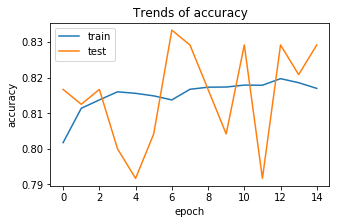



ACC:  0.8148333333333333
AUC:  0.7634532726402778
Log Loss:  0.44149853618722407


Confusion Matrix: 
[[4364  299]
 [ 812  525]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4663
           1       0.64      0.39      0.49      1337

   micro avg       0.81      0.81      0.81      6000
   macro avg       0.74      0.66      0.69      6000
weighted avg       0.80      0.81      0.80      6000
 samples avg       0.81      0.81      0.81      6000



In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size =.2, random_state=1)

model = Sequential()
model.add(Dense(512, input_shape=(X.shape[1],)))
model.add(Activation("elu"))
model.add(Dropout(.3))
    
model.add(Dense(256))
model.add(Activation("elu"))
model.add(Dropout(.2))
    
model.add(Dense(128))
model.add(Activation("elu"))
model.add(Dropout(.1))
    
model.add(Dense(64))
model.add(Activation("elu"))
model.add(Dropout(.05))

model.add(Dense(2))
model.add(Activation("softmax"))

keras.regularizers.l1_l2(l1=.01, l2=.01)
keras.initializers.he_normal
print(model.summary())

model.compile(loss=keras.losses.binary_crossentropy, optimizer=OPTIMIZER, metrics=["accuracy"])
    


history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE,
                   epochs=NB_EPOCH, verbose=VERBOSE, validation_split=.01)

plt.figure(figsize=(5, 3))
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.title("Trends of accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()
pred_proba = model.predict(X_test)
pred = (pred_proba > 0.5).astype(int)
print("\n")
print("ACC: ", accuracy_score(Y_test, pred))
print("AUC: ", roc_auc_score(Y_test, pred_proba))
print("Log Loss: ", log_loss(Y_test, pred_proba))
print("\n")
print("Confusion Matrix: ")
print(confusion_matrix(Y_test[:,1], pred[:,1]))
## 넣는 형식 바꿀 것
print("\n")
print("Classification Report: ")
print(classification_report(Y_test, pred))
acc = []
acc.append(accuracy_score(Y_test, pred))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               13824     
_________________________________________________________________
activation_6 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_7 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
__________

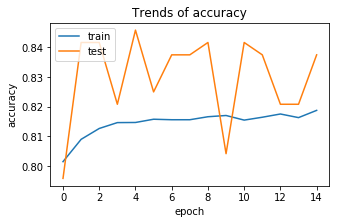



ACC:  0.8183333333333334
AUC:  0.7825224096888536
Log Loss:  0.43891487845033406


Confusion Matrix: 
[[4480  185]
 [ 905  430]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      4665
           1       0.70      0.32      0.44      1335

   micro avg       0.82      0.82      0.82      6000
   macro avg       0.77      0.64      0.67      6000
weighted avg       0.80      0.82      0.79      6000
 samples avg       0.82      0.82      0.82      6000



In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size =.2, random_state=2)

model = Sequential()
model.add(Dense(512, input_shape=(X.shape[1],)))
model.add(Activation("elu"))
model.add(Dropout(.3))
    
model.add(Dense(256))
model.add(Activation("elu"))
model.add(Dropout(.2))
    
model.add(Dense(128))
model.add(Activation("elu"))
model.add(Dropout(.1))
    
model.add(Dense(64))
model.add(Activation("elu"))
model.add(Dropout(.05))

model.add(Dense(2))
model.add(Activation("softmax"))

keras.regularizers.l1_l2(l1=.01, l2=.01)
keras.initializers.he_normal
print(model.summary())

model.compile(loss=keras.losses.binary_crossentropy, optimizer=OPTIMIZER, metrics=["accuracy"])
    


history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE,
                   epochs=NB_EPOCH, verbose=VERBOSE, validation_split=.01)

plt.figure(figsize=(5, 3))
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.title("Trends of accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()
pred_proba = model.predict(X_test)
pred = (pred_proba > 0.5).astype(int)
print("\n")
print("ACC: ", accuracy_score(Y_test, pred))
print("AUC: ", roc_auc_score(Y_test, pred_proba))
print("Log Loss: ", log_loss(Y_test, pred_proba))
print("\n")
print("Confusion Matrix: ")
print(confusion_matrix(Y_test[:,1], pred[:,1]))
## 넣는 형식 바꿀 것
print("\n")
print("Classification Report: ")
print(classification_report(Y_test, pred))
acc.append(accuracy_score(Y_test, pred))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 512)               13824     
_________________________________________________________________
activation_11 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
activation_12 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               32896     
__________

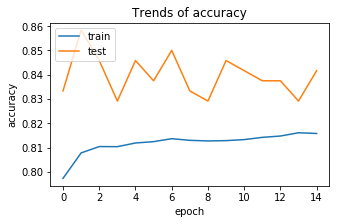



ACC:  0.83
AUC:  0.7808178355238191
Log Loss:  0.4137329321289435


Confusion Matrix: 
[[4458  290]
 [ 730  522]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      4748
           1       0.64      0.42      0.51      1252

   micro avg       0.83      0.83      0.83      6000
   macro avg       0.75      0.68      0.70      6000
weighted avg       0.81      0.83      0.82      6000
 samples avg       0.83      0.83      0.83      6000



In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size =.2, random_state=3)

model = Sequential()
model.add(Dense(512, input_shape=(X.shape[1],)))
model.add(Activation("elu"))
model.add(Dropout(.3))
    
model.add(Dense(256))
model.add(Activation("elu"))
model.add(Dropout(.2))
    
model.add(Dense(128))
model.add(Activation("elu"))
model.add(Dropout(.1))
    
model.add(Dense(64))
model.add(Activation("elu"))
model.add(Dropout(.05))

model.add(Dense(2))
model.add(Activation("softmax"))

keras.regularizers.l1_l2(l1=.01, l2=.01)
keras.initializers.he_normal
print(model.summary())

model.compile(loss=keras.losses.binary_crossentropy, optimizer=OPTIMIZER, metrics=["accuracy"])
    


history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE,
                   epochs=NB_EPOCH, verbose=VERBOSE, validation_split=.01)

plt.figure(figsize=(5, 3))
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.title("Trends of accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()
pred_proba = model.predict(X_test)
pred = (pred_proba > 0.5).astype(int)
print("\n")
print("ACC: ", accuracy_score(Y_test, pred))
print("AUC: ", roc_auc_score(Y_test, pred_proba))
print("Log Loss: ", log_loss(Y_test, pred_proba))
print("\n")
print("Confusion Matrix: ")
print(confusion_matrix(Y_test[:,1], pred[:,1]))
## 넣는 형식 바꿀 것
print("\n")
print("Classification Report: ")
print(classification_report(Y_test, pred))
acc.append(accuracy_score(Y_test, pred))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 512)               13824     
_________________________________________________________________
activation_21 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               131328    
_________________________________________________________________
activation_22 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 128)               32896     
__________

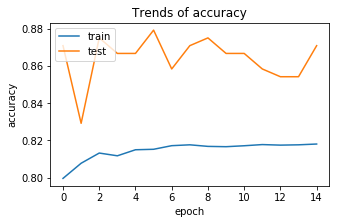



ACC:  0.8171666666666667
AUC:  0.7467964791902936
Log Loss:  0.4470127627272159


Confusion Matrix: 
[[4388  250]
 [ 847  515]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4638
           1       0.67      0.38      0.48      1362

   micro avg       0.82      0.82      0.82      6000
   macro avg       0.76      0.66      0.69      6000
weighted avg       0.80      0.82      0.80      6000
 samples avg       0.82      0.82      0.82      6000



In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size =.2, random_state=4)

model = Sequential()
model.add(Dense(512, input_shape=(X.shape[1],)))
model.add(Activation("elu"))
model.add(Dropout(.3))
    
model.add(Dense(256))
model.add(Activation("elu"))
model.add(Dropout(.2))
    
model.add(Dense(128))
model.add(Activation("elu"))
model.add(Dropout(.1))
    
model.add(Dense(64))
model.add(Activation("elu"))
model.add(Dropout(.05))

model.add(Dense(2))
model.add(Activation("softmax"))

keras.regularizers.l1_l2(l1=.01, l2=.01)
keras.initializers.he_normal
print(model.summary())

model.compile(loss=keras.losses.binary_crossentropy, optimizer=OPTIMIZER, metrics=["accuracy"])
    


history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE,
                   epochs=NB_EPOCH, verbose=VERBOSE, validation_split=.01)

plt.figure(figsize=(5, 3))
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.title("Trends of accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()
pred_proba = model.predict(X_test)
pred = (pred_proba > 0.5).astype(int)
print("\n")
print("ACC: ", accuracy_score(Y_test, pred))
print("AUC: ", roc_auc_score(Y_test, pred_proba))
print("Log Loss: ", log_loss(Y_test, pred_proba))
print("\n")
print("Confusion Matrix: ")
print(confusion_matrix(Y_test[:,1], pred[:,1]))
## 넣는 형식 바꿀 것
print("\n")
print("Classification Report: ")
print(classification_report(Y_test, pred))
acc.append(accuracy_score(Y_test, pred))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 512)               13824     
_________________________________________________________________
activation_16 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               131328    
_________________________________________________________________
activation_17 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               32896     
__________

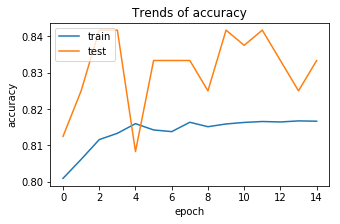



ACC:  0.821
AUC:  0.7725603217007828
Log Loss:  0.4407828520005569


Confusion Matrix: 
[[4445  216]
 [ 858  481]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4661
           1       0.69      0.36      0.47      1339

   micro avg       0.82      0.82      0.82      6000
   macro avg       0.76      0.66      0.68      6000
weighted avg       0.81      0.82      0.80      6000
 samples avg       0.82      0.82      0.82      6000



In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size =.2, random_state=5)

model = Sequential()
model.add(Dense(512, input_shape=(X.shape[1],)))
model.add(Activation("elu"))
model.add(Dropout(.3))
    
model.add(Dense(256))
model.add(Activation("elu"))
model.add(Dropout(.2))
    
model.add(Dense(128))
model.add(Activation("elu"))
model.add(Dropout(.1))
    
model.add(Dense(64))
model.add(Activation("elu"))
model.add(Dropout(.05))

model.add(Dense(2))
model.add(Activation("softmax"))

keras.regularizers.l1_l2(l1=.01, l2=.01)
keras.initializers.he_normal
print(model.summary())

model.compile(loss=keras.losses.binary_crossentropy, optimizer=OPTIMIZER, metrics=["accuracy"])
    


history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE,
                   epochs=NB_EPOCH, verbose=VERBOSE, validation_split=.01)

plt.figure(figsize=(5, 3))
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.title("Trends of accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()
pred_proba = model.predict(X_test)
pred = (pred_proba > 0.5).astype(int)
print("\n")
print("ACC: ", accuracy_score(Y_test, pred))
print("AUC: ", roc_auc_score(Y_test, pred_proba))
print("Log Loss: ", log_loss(Y_test, pred_proba))
print("\n")
print("Confusion Matrix: ")
print(confusion_matrix(Y_test[:,1], pred[:,1]))
## 넣는 형식 바꿀 것
print("\n")
print("Classification Report: ")
print(classification_report(Y_test, pred))
acc.append(accuracy_score(Y_test, pred))

In [22]:
acc

[0.8148333333333333, 0.8183333333333334, 0.83, 0.821, 0.8171666666666667]

In [23]:
print(np.mean(acc))
print(np.std(acc))

0.8202666666666667
0.00525631894855028
